### Package Dependecies

Make a new environment in conda  with python 3.6 ```conda create --name myenv python=3.6``` 

Check to see that the correct version of python is installed by using this command ```python --version```

Install jupyter ```conda install jupyter```

Install keras ```conda install keras```

Install tensorflow 1.14 ```conda install tensorflow=1.14```

Install Pillow 6.1 ```conda install pillow=6.1```

Install Matplotlib 3.1 ```conda install matplotlib=3.1```

In [16]:
conda install keras


Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.1
  latest version: 24.5.0

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /cm/shared/apps/spack/0.17.3/gpu/b/opt/spack/linux-rocky8-skylake_avx512/gcc-8.5.0/anaconda3-2021.05-kfluefzsateihlamuk2qihp56exwe7si

  added / updated specs:
    - keras


The following NEW packages will be INSTALLED:

  keras              pkgs/main/linux-64::keras-2.12.0-py38h06a4308_0
  keras-preprocessi~ pkgs/main/noarch::keras-preprocessing-1.1.2-pyhd3eb1b0_0


Preparing transaction: done
Verifying transaction: failed

EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: /cm/shared/apps/spack/0.17.3/gpu/b/opt/spack/linux-rocky8-skylake_avx512/gcc-8.5.0/anaconda3-2021.05-kfluefzsateihlamuk2qihp56exwe7si
  uid: 534666
  gid: 10853



Note: you may need to re

In [17]:
#conda install tensorflow=1.14
#from keras.utils import np_utils

In [18]:
# ----------- IMPORT STATEMENTS ---------------
import numpy as np
np.random.seed(1)  # for reproducibility

from keras.models import Sequential               #Sequential models are the standard stack of layers models
from keras.layers import Dense, Dropout, Activation, Flatten   #These are core layer specification functions
from keras.layers import Convolution2D, MaxPooling2D           #These are convolution layer functions
#from keras.utils import np_utils  
from keras.utils import to_categorical
#Some utilities
from keras import optimizers                             #For training algorithm
#---------------------------------------------
print('import done')

import done


In [19]:
#--------------- LOAD and PREPARE DATA STATEMENTS ----------------
# Load some numpy arrays that have the MNIST data
#  (these are subsets extracted from the MNIST data set in Keras)
X_train=np.load('X_train5k.npy')
Y_train=np.load('Y_train5k.npy')
X_test =np.load('X_test.npy')
Y_test =np.load('Y_test.npy')

print(X_train.shape)     #review the dimensions Note python3 uses print(X..) python 2 uses print X...

#save a few training images with the label in the file name 
from PIL import Image
for i in range(0,3):
   im = Image.fromarray(X_train[i,:,:])
   im.save("Xtrain_num"+str(i)+"_cat_"+str(Y_train[i])+".jpeg")
print('img load done')

(5000, 28, 28)
img load done


In [20]:
from keras.utils import to_categorical

# Reshape input data
X_train = X_train.reshape(X_train.shape[0], 1, 28, 28)
X_test = X_test.reshape(X_test.shape[0], 1, 28, 28)

# Convert input data to float32 and put into 0-1 range
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# One-hot encode labels
Y_train = to_categorical(Y_train, 10)
Y_test = to_categorical(Y_test, 10)

# Print maximum value of X_train
print(np.amax(X_train))  # This gets the max value over a flattened numpy array
print('prep done')


1.0
prep done


In [21]:
# --------------Set up Model ---------------------
mymodel = Sequential()

numfilters = 16
#add convolution layer of 32 or 16 or __ filters, 3x3 each, 
#     input shape for 1 image, channels refers to color dimension of input image
mymodel.add(Convolution2D(numfilters, (3, 3),strides=1,  data_format="channels_first",activation='relu', input_shape=(1,28,28))) 
 
print('modeldef and first conv layer done')


modeldef and first conv layer done


In [22]:
mymodel.layers[0].output # use this to check sizes of output  

<KerasTensor: shape=(None, 16, 26, 26) dtype=float32 (created by layer 'conv2d_2')>

In [23]:
#-----------------Now add more Convolution layers
mymodel.add(Convolution2D(numfilters, (3, 3), activation='relu'))
mymodel.add(MaxPooling2D(pool_size=(2,2))) #get Max over 2D region,and slide

#optional?
mymodel.add(Dropout(0.25))
 
mymodel.add(Flatten())            #reorganize 2DxFilters output into 1D

In [24]:
mymodel.layers[2].output   #size of output layer for max pooling

<KerasTensor: shape=(None, 7, 12, 16) dtype=float32 (created by layer 'max_pooling2d_1')>

In [25]:
#----------------Now add final classification layers
mymodel.add(Dense(128, activation='relu'))  #enter number of hidden units (no good rule, but start with ~ num of previous output) 
mymodel.add(Dropout(0.5))
mymodel.add(Dense(10, activation='softmax'))
print('assemble model done')

assemble model done


In [26]:
# --------- Now assemble (ie compile TensorFlow commands) and run -----
mymodel.compile(loss='categorical_crossentropy',
               optimizer='sgd',
               metrics=['accuracy'])

In [27]:
#------------ Now Run Training
mymodel.fit(X_train, Y_train, 
          batch_size=32, epochs=15, verbose=1)  #batch up 32 examples before adjusting weights,
                                                #sweep through training data 'epochs' times


Epoch 1/15
157/157 [==============================] - 1s 3ms/step - loss: 2.1903 - accuracy: 0.2134
Epoch 2/15
157/157 [==============================] - 0s 3ms/step - loss: 1.4389 - accuracy: 0.5344
Epoch 3/15
157/157 [==============================] - 0s 3ms/step - loss: 0.9072 - accuracy: 0.7078
Epoch 4/15
157/157 [==============================] - 0s 3ms/step - loss: 0.7464 - accuracy: 0.7638
Epoch 5/15
157/157 [==============================] - 0s 3ms/step - loss: 0.6236 - accuracy: 0.8032
Epoch 6/15
157/157 [==============================] - 0s 3ms/step - loss: 0.5652 - accuracy: 0.8288
Epoch 7/15
157/157 [==============================] - 0s 3ms/step - loss: 0.5123 - accuracy: 0.8478
Epoch 8/15
157/157 [==============================] - 0s 3ms/step - loss: 0.4832 - accuracy: 0.8566
Epoch 9/15
157/157 [==============================] - 0s 3ms/step - loss: 0.4324 - accuracy: 0.8718
Epoch 10/15
157/157 [==============================] - 0s 3ms/step - loss: 0.4175 - accuracy: 0.8760

In [28]:
#--------- Get overall prediction score
trainscore = mymodel.evaluate(X_train, Y_train, verbose=1) # get overal score
testscore  = mymodel.evaluate(X_test, Y_test, verbose=1) # get overal score
#somepred  = mymodel.predict(X_test,verbose=0)           # get predicted labels
print(trainscore)
print(testscore)

313/313 [==============================] - 0s 1ms/step - loss: 0.2206 - accuracy: 0.9333
[0.16924729943275452, 0.9549999833106995]
[0.220572829246521, 0.9333000183105469]


In [29]:
#-----------Optional: View some of the output
#print(somepred[1:3])
#Notice each row is 10 elements, each element is a prediction of the number labels 
print(Y_test[1:3])

[[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


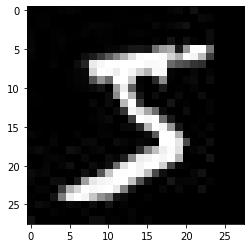

im loaded


In [30]:
#To view a sample image
import matplotlib.pyplot as plt      #These provide matlab type of plotting functions
import matplotlib.image as mpimg

img_filename = "Xtrain_num0_cat_5.jpeg" #% scriptDir 
im = mpimg.imread(img_filename)
plt.figure()
plt.imshow(im,'gray')
plt.show()
print('im loaded')

4.0


<ipython-input-31-aed5cdde8caa>:15: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrow,ncol,i+1)


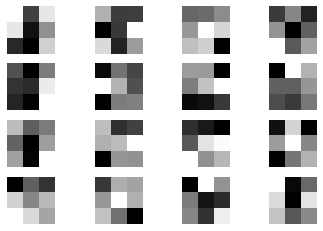

done plotting weights mosaic


In [31]:
# ------------ GET WEIGHTS From Convolution Layer and make mosaic image 
Wlist   =mymodel.layers[0].get_weights()
W3D     =np.squeeze(Wlist[0])
W3D.shape
W3Dchan =W3D.swapaxes(1,2).swapaxes(0,1)  #get 32 as 1st dimension

Wmin       =np.amin(W3Dchan)
Wmax       =np.amax(W3Dchan-Wmin)
Wsc        =np.int_(255*(W3Dchan-Wmin)/Wmax)
ncol =4
nrow =np.ceil(numfilters/ncol)
print(nrow)
plt.figure()
for i in range(Wsc.shape[0]):
   plt.subplot(nrow,ncol,i+1)
   plt.imshow(Wsc[i],'gray')
   plt.axis('off')
#plt.savefig("test.png", bbox_inches='tight')
plt.show()
print('done plotting weights mosaic')

In [32]:
#  ---------------- NOW Visualize the activations for the first training example --------
from keras import backend as K    #backend is tensorflow

get_layer_output = K.function([mymodel.layers[0].input],[mymodel.layers[0].output]) #set up function
x                = np.expand_dims(X_train[0],0)           #set up a 4D input of 1 image training set 
layer_output     = get_layer_output([x])[0]  #get output using K.function

layer_output.shape    #check output shape and use it in next cell, first dimension is number of filters



(1, 16, 26, 26)

<ipython-input-33-e2c09716b56a>:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(nrow,ncol,i+1)


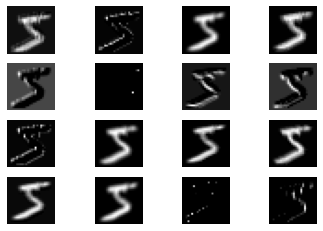

done plotting layer activation output mosaic


In [33]:
# --- Now output a mosaic
layeroutput3D      = np.squeeze(layer_output)      
ncol =4
nrow =np.ceil(numfilters/ncol)
plt.figure()
for i in range(layeroutput3D.shape[0]):
   plt.subplot(nrow,ncol,i+1)
   plt.imshow(layeroutput3D[i],'gray')
   plt.axis('off')
#plt.savefig("test.png", bbox_inches='tight')
plt.show()
print('done plotting layer activation output mosaic')
